[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Saving FAKE AND REAL NEWS.csv to FAKE AND REAL NEWS (2).csv
Model Performance:
Accuracy: 0.9833333333333333
Precision: 0.9836065573770492
Recall: 0.9836065573770492
F1 Score: 0.9836065573770492

Classification Report:
               precision    recall  f1-score   support

        Fake       0.98      0.98      0.98       118
        Real       0.98      0.98      0.98       122

    accuracy                           0.98       240
   macro avg       0.98      0.98      0.98       240
weighted avg       0.98      0.98      0.98       240



/tmp/ipython-input-8-847069348.py:78: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df['label'], palette='Set2')


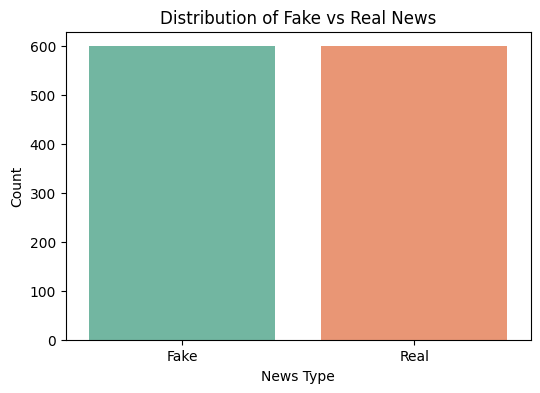

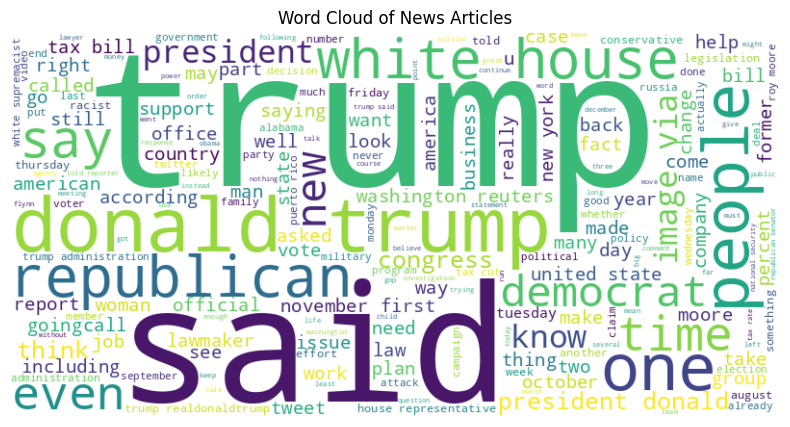

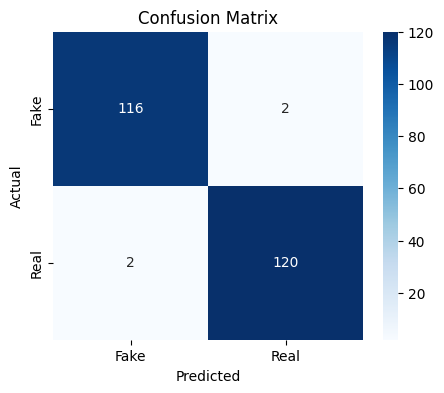

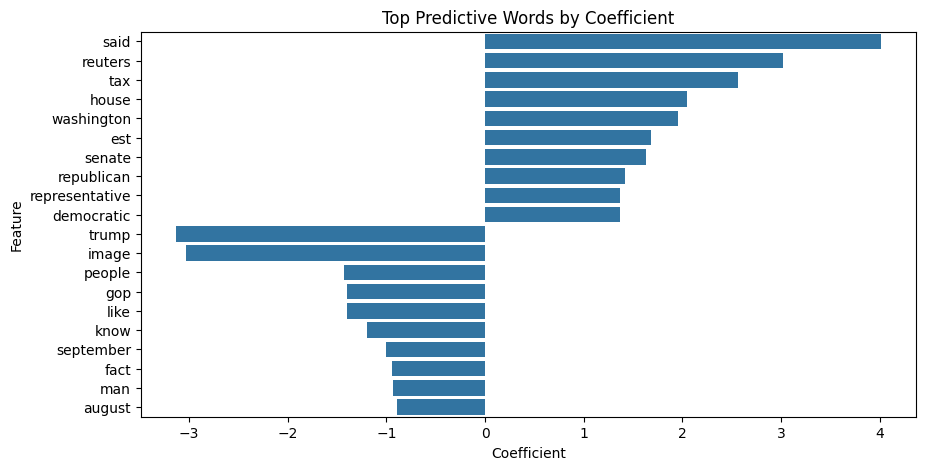


Model and TF-IDF vectorizer saved as 'news_classifier_model.pkl' and 'tfidf_vectorizer.pkl'

Enter a news article to classify (type 'exit' to quit):

Enter the article title (or 'exit' to quit): NASA Confirms Earth Will Go Dark for 6 Days in December 2025
Enter the article text: NASA has announced a rare cosmic event that will plunge the Earth into total darkness for six days straight. The phenomenon, due to planetary alignment, will block sunlight entirely

Prediction: Fake
Probabilities: Fake=0.67, Real=0.33


Enter the article title (or 'exit' to quit): exit
Exiting...


In [8]:
# TruthNet: Real vs Fake News Classification using NLP and TF-IDF

import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import joblib
from google.colab import files
# Download required NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Step 1: Load and prepare the dataset
# Replace with your actual CSV file name
uploaded = files.upload()
df = pd.read_csv('FAKE AND REAL NEWS.csv')

# Create binary labels: politicsNews = 1 (real), News = 0 (fake)
df['label'] = df['subject'].apply(lambda x: 1 if x == 'politicsNews' else 0)

# Combine title and text for feature extraction
df['combined_text'] = df['title'] + ' ' + df['text']

# Step 2: Text Preprocessing
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'\d+', '', text)
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(token) for token in tokens
              if token not in string.punctuation
              and token.isalpha()
              and token not in stop_words]
    return ' '.join(tokens)

# Apply preprocessing
df['processed_text'] = df['combined_text'].apply(preprocess_text)

# Step 3: Feature Extraction with TF-IDF
tfidf = TfidfVectorizer(max_features=5000, stop_words='english')
X = tfidf.fit_transform(df['processed_text'])
y = df['label']

# Step 4: Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 5: Train Logistic Regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Step 6: Evaluate the model
y_pred = model.predict(X_test)
print("Model Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=['Fake', 'Real']))

# Step 7: Visualizations

# Label distribution
plt.figure(figsize=(6, 4))
sns.countplot(x=df['label'], palette='Set2')
plt.title('Distribution of Fake vs Real News')
plt.xticks([0, 1], ['Fake', 'Real'])
plt.xlabel('News Type')
plt.ylabel('Count')
plt.show()

# Word cloud
text_all = ' '.join(df['processed_text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_all)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of News Articles')
plt.show()

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Top TF-IDF features
feature_names = tfidf.get_feature_names_out()
coefficients = model.coef_[0]
top_positive_indices = coefficients.argsort()[-10:][::-1]
top_negative_indices = coefficients.argsort()[:10]

top_features = [(feature_names[i], coefficients[i]) for i in top_positive_indices]
bottom_features = [(feature_names[i], coefficients[i]) for i in top_negative_indices]

top_df = pd.DataFrame(top_features + bottom_features, columns=['Feature', 'Coefficient'])
plt.figure(figsize=(10, 5))
sns.barplot(x='Coefficient', y='Feature', data=top_df)
plt.title('Top Predictive Words by Coefficient')
plt.show()

# Step 8: Function to classify new articles
def classify_article(title, text, model, tfidf):
    combined = title + ' ' + text
    processed = preprocess_text(combined)
    tfidf_vector = tfidf.transform([processed])
    prediction = model.predict(tfidf_vector)
    probability = model.predict_proba(tfidf_vector)
    return 'Real' if prediction[0] == 1 else 'Fake', probability[0]

# Step 9: Interactive User Input
def predict_user_input():
    print("\nEnter a news article to classify (type 'exit' to quit):")
    while True:
        title = input("\nEnter the article title (or 'exit' to quit): ")
        if title.lower() == 'exit':
            print("Exiting...")
            break
        text = input("Enter the article text: ")
        if text.lower() == 'exit':
            print("Exiting...")
            break
        label, prob = classify_article(title, text, model, tfidf)
        print(f"\nPrediction: {label}")
        print(f"Probabilities: Fake={prob[0]:.2f}, Real={prob[1]:.2f}\n")

# Step 10: Save model and vectorizer
joblib.dump(model, 'news_classifier_model.pkl')
joblib.dump(tfidf, 'tfidf_vectorizer.pkl')
print("\nModel and TF-IDF vectorizer saved as 'news_classifier_model.pkl' and 'tfidf_vectorizer.pkl'")

# Step 11: Run interactive mode
predict_user_input()
